In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import load

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Days to predict
days = 3

# Size of data split for testing
train_size = 0.9

In [6]:
# Train-Test split
split = int(len(data) * train_size)

train = data.to_numpy()[:split]
test = data.to_numpy()[split:]

In [7]:
# Load normalisers
normaliser = load('./normalisers/x_normaliser.joblib')
y_normaliser = load('./normalisers/y_normaliser.joblib')

In [8]:
# Normalise data
train_norm = normaliser.transform(train)
test_norm = normaliser.transform(test)

##### Now I get indexes for chunks from 3 in 3 days

In [9]:
index = []

for i in range(days):
    index.append(np.arange(i,len(train),days))

In [10]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [11]:
# Normalised train chunks
X_train = np.array([train_norm[ix].copy() for ix in ordered_index])
Y_train = np.array([train_norm[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
Y_train = np.expand_dims(Y_train, -1)

In [12]:
# Delete those sequences that doesn't have a -th day in the results
X_train = X_train[:Y_train.shape[0]]

##### Same for test

In [13]:
index = []

for i in range(days):
    index.append(np.arange(i,len(test),days))

In [14]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [15]:
# Normalised train chunks
X_test = np.array([test_norm[ix].copy() for ix in ordered_index])
Y_test = np.array([test_norm[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
Y_test = np.expand_dims(Y_test, -1)

In [16]:
# Delete those sequences that doesn't have a -th day in the results
X_test = X_test[:Y_test.shape[0]]

# Model selection

##### Model constructor

In [17]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [18]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [19]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [20]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 2s 566us/step - loss: 0.0239 - val_loss: 0.0171
Epoch 2/24
3977/3977 [==============================] - 1s 297us/step - loss: 0.0233 - val_loss: 0.0127
Epoch 3/24
3977/3977 [==============================] - 1s 295us/step - loss: 0.0249 - val_loss: 0.0284
Epoch 4/24
3977/3977 [==============================] - 1s 297us/step - loss: 0.0638 - val_loss: 0.0101
Epoch 5/24
3977/3977 [==============================] - 1s 302us/step - loss: 0.0145 - val_loss: 0.0061
Epoch 6/24
3977/3977 [==============================] - 1s 297us/step - loss: 0.0268 - val_loss: 0.0024
Epoch 7/24
3977/3977 [==============================] - 1s 296us/step - loss: 0.0243 - val_loss: 0.0015
Epoch 8/24
3977/3977 [==============================] - 1s 298us/step - loss: 0.0308 - val

Epoch 24/24
3977/3977 [==============================] - 2s 487us/step - loss: 9.2508e-04 - val_loss: 9.2182e-04
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 3s 717us/step - loss: 0.0815 - val_loss: 0.0019
Epoch 2/24
3977/3977 [==============================] - 2s 487us/step - loss: 0.0123 - val_loss: 0.0119
Epoch 3/24
3977/3977 [==============================] - 2s 489us/step - loss: 0.0060 - val_loss: 0.0038
Epoch 4/24
3977/3977 [==============================] - 2s 487us/step - loss: 0.0033 - val_loss: 0.0065
Epoch 5/24
3977/3977 [==============================] - 2s 487us/step - loss: 0.0026 - val_loss: 0.0015
Epoch 6/24
3977/3977 [==============================] - 2s 487us/step - loss: 0.0021 - val_loss: 0.0025
Epoch 7/24
3977/3977 [==============================] - 2s 493us/step - loss: 0.0017 - val_loss: 0.0030
Epoch 8/24
3977/3977 [==============================] - 2s 486us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/

Epoch 4/24
3977/3977 [==============================] - 2s 487us/step - loss: 0.0058 - val_loss: 0.0972
Epoch 5/24
3977/3977 [==============================] - 2s 489us/step - loss: 0.0232 - val_loss: 0.0029
Epoch 6/24
3977/3977 [==============================] - 2s 491us/step - loss: 0.0020 - val_loss: 0.0134
Epoch 7/24
3977/3977 [==============================] - 2s 488us/step - loss: 0.0345 - val_loss: 0.0337
Epoch 8/24
3977/3977 [==============================] - 2s 492us/step - loss: 0.0057 - val_loss: 0.0038
Epoch 9/24
3977/3977 [==============================] - 2s 491us/step - loss: 0.0100 - val_loss: 0.0646
Epoch 10/24
3977/3977 [==============================] - 2s 490us/step - loss: 0.0344 - val_loss: 0.0040
Epoch 11/24
3977/3977 [==============================] - 2s 486us/step - loss: 0.0017 - val_loss: 0.0053
Epoch 12/24
3977/3977 [==============================] - 2s 487us/step - loss: 0.0127 - val_loss: 0.0238
Epoch 13/24
3977/3977 [==============================] - 2s 4

Epoch 9/24
3977/3977 [==============================] - 2s 522us/step - loss: 0.0181 - val_loss: 0.0049
Epoch 10/24
3977/3977 [==============================] - 2s 524us/step - loss: 0.0154 - val_loss: 0.0040
Epoch 11/24
3977/3977 [==============================] - 2s 526us/step - loss: 0.0134 - val_loss: 0.0033
Epoch 12/24
3977/3977 [==============================] - 2s 522us/step - loss: 0.0117 - val_loss: 0.0028
Epoch 13/24
3977/3977 [==============================] - 2s 522us/step - loss: 0.0103 - val_loss: 0.0025
Epoch 14/24
3977/3977 [==============================] - 2s 519us/step - loss: 0.0091 - val_loss: 0.0023
Epoch 15/24
3977/3977 [==============================] - 2s 525us/step - loss: 0.0081 - val_loss: 0.0023
Epoch 16/24
3977/3977 [==============================] - 2s 522us/step - loss: 0.0078 - val_loss: 0.0024
Epoch 17/24
3977/3977 [==============================] - 2s 527us/step - loss: 0.0068 - val_loss: 0.0024
Epoch 18/24
3977/3977 [==============================] -

3977/3977 [==============================] - 1s 333us/step - loss: 0.0118 - val_loss: 0.0324
Epoch 18/24
3977/3977 [==============================] - 1s 332us/step - loss: 0.0156 - val_loss: 0.0182
Epoch 19/24
3977/3977 [==============================] - 1s 329us/step - loss: 0.0053 - val_loss: 0.0032
Epoch 20/24
3977/3977 [==============================] - 1s 318us/step - loss: 0.0029 - val_loss: 0.0025
Epoch 21/24
3977/3977 [==============================] - 1s 329us/step - loss: 0.0028 - val_loss: 0.0019
Epoch 22/24
3977/3977 [==============================] - 1s 316us/step - loss: 0.0075 - val_loss: 0.0153
Epoch 23/24
3977/3977 [==============================] - 1s 314us/step - loss: 0.0183 - val_loss: 0.0082
Epoch 24/24
3977/3977 [==============================] - 1s 314us/step - loss: 0.0066 - val_loss: 0.0019
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 3s 776us/step - loss: 0.0990 - val_loss: 0.0035
Epoch 2/24
3977/3977 

3977/3977 [==============================] - 1s 323us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 23/24
3977/3977 [==============================] - 1s 318us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 24/24
3977/3977 [==============================] - 1s 314us/step - loss: 0.0019 - val_loss: 0.0014

GENERATION 2

Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 4s 971us/step - loss: 0.1656 - val_loss: 0.0025
Epoch 2/24
3977/3977 [==============================] - 2s 490us/step - loss: 0.0042 - val_loss: 0.0020
Epoch 3/24
3977/3977 [==============================] - 2s 487us/step - loss: 0.0095 - val_loss: 0.0016
Epoch 4/24
3977/3977 [==============================] - 2s 490us/step - loss: 0.0067 - val_loss: 0.0302
Epoch 5/24
3977/3977 [==============================] - 2s 485us/step - loss: 0.0100 - val_loss: 0.0150
Epoch 6/24
3977/3977 [==============================] - 2s 487us/step - loss: 0.0139 - val_loss: 0.0064
Epoch 7/24


Epoch 2/24
3977/3977 [==============================] - 2s 532us/step - loss: 0.0138 - val_loss: 0.0143
Epoch 3/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0100 - val_loss: 0.0227
Epoch 4/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0138 - val_loss: 0.0223
Epoch 5/24
3977/3977 [==============================] - 2s 532us/step - loss: 0.0136 - val_loss: 0.0220
Epoch 6/24
3977/3977 [==============================] - 2s 533us/step - loss: 0.0159 - val_loss: 0.0237
Epoch 7/24
3977/3977 [==============================] - 2s 533us/step - loss: 0.0139 - val_loss: 0.0250
Epoch 8/24
3977/3977 [==============================] - 2s 534us/step - loss: 0.0137 - val_loss: 0.0093
Epoch 9/24
3977/3977 [==============================] - 2s 534us/step - loss: 0.0144 - val_loss: 0.0200
Epoch 10/24
3977/3977 [==============================] - 2s 532us/step - loss: 0.0113 - val_loss: 0.0141
Epoch 11/24
3977/3977 [==============================] - 2s 535

3977/3977 [==============================] - 2s 562us/step - loss: 0.0550 - val_loss: 0.0021
Epoch 8/24
3977/3977 [==============================] - 2s 526us/step - loss: 0.0038 - val_loss: 0.0145
Epoch 9/24
3977/3977 [==============================] - 2s 516us/step - loss: 0.0184 - val_loss: 0.0170
Epoch 10/24
3977/3977 [==============================] - 2s 514us/step - loss: 0.0100 - val_loss: 0.0325
Epoch 11/24
3977/3977 [==============================] - 2s 519us/step - loss: 0.0171 - val_loss: 0.0423
Epoch 12/24
3977/3977 [==============================] - 2s 542us/step - loss: 0.0405 - val_loss: 0.0030
Epoch 13/24
3977/3977 [==============================] - 2s 523us/step - loss: 0.0028 - val_loss: 0.0043
Epoch 14/24
3977/3977 [==============================] - 2s 530us/step - loss: 0.0093 - val_loss: 0.0220
Epoch 15/24
3977/3977 [==============================] - 2s 517us/step - loss: 0.0064 - val_loss: 0.0262
Epoch 16/24
3977/3977 [==============================] - 2s 518us/ste

Epoch 12/24
3977/3977 [==============================] - 2s 489us/step - loss: 0.0010 - val_loss: 9.9395e-04
Epoch 13/24
3977/3977 [==============================] - 2s 489us/step - loss: 0.0010 - val_loss: 9.7816e-04
Epoch 14/24
3977/3977 [==============================] - 2s 488us/step - loss: 9.8881e-04 - val_loss: 0.0012
Epoch 15/24
3977/3977 [==============================] - 2s 488us/step - loss: 9.7128e-04 - val_loss: 9.4092e-04
Epoch 16/24
3977/3977 [==============================] - 2s 488us/step - loss: 9.3606e-04 - val_loss: 9.3092e-04
Epoch 17/24
3977/3977 [==============================] - 2s 491us/step - loss: 9.2115e-04 - val_loss: 9.2529e-04
Epoch 18/24
3977/3977 [==============================] - 2s 489us/step - loss: 9.1665e-04 - val_loss: 9.0161e-04
Epoch 19/24
3977/3977 [==============================] - 2s 489us/step - loss: 9.0272e-04 - val_loss: 9.6464e-04
Epoch 20/24
3977/3977 [==============================] - 2s 497us/step - loss: 9.1384e-04 - val_loss: 8.7513

Epoch 16/24
3977/3977 [==============================] - 2s 513us/step - loss: 0.0023 - val_loss: 0.0015
Epoch 17/24
3977/3977 [==============================] - 2s 511us/step - loss: 0.0023 - val_loss: 0.0016
Epoch 18/24
3977/3977 [==============================] - 2s 511us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 19/24
3977/3977 [==============================] - 2s 512us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 20/24
3977/3977 [==============================] - 2s 513us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 21/24
3977/3977 [==============================] - 2s 510us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 22/24
3977/3977 [==============================] - 2s 511us/step - loss: 0.0022 - val_loss: 0.0012
Epoch 23/24
3977/3977 [==============================] - 2s 513us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 24/24
3977/3977 [==============================] - 2s 511us/step - loss: 0.0021 - val_loss: 0.0012
Train on 3977 samples, validate on 442 samples
Epoch 1/

Epoch 21/24
3977/3977 [==============================] - 2s 510us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 22/24
3977/3977 [==============================] - 2s 514us/step - loss: 0.0031 - val_loss: 0.0022
Epoch 23/24
3977/3977 [==============================] - 2s 516us/step - loss: 0.0031 - val_loss: 0.0020
Epoch 24/24
3977/3977 [==============================] - 2s 511us/step - loss: 0.0031 - val_loss: 0.0018
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 6s 1ms/step - loss: 0.3605 - val_loss: 0.0028
Epoch 2/24
3977/3977 [==============================] - 2s 451us/step - loss: 0.0087 - val_loss: 0.0018
Epoch 3/24
3977/3977 [==============================] - 2s 450us/step - loss: 0.0060 - val_loss: 0.0020
Epoch 4/24
3977/3977 [==============================] - 2s 452us/step - loss: 0.0050 - val_loss: 0.0020
Epoch 5/24
3977/3977 [==============================] - 2s 451us/step - loss: 0.0049 - val_loss: 0.0020
Epoch 6/24
3977

3977/3977 [==============================] - 6s 2ms/step - loss: 0.0822 - val_loss: 0.0037
Epoch 2/24
3977/3977 [==============================] - 2s 490us/step - loss: 0.0103 - val_loss: 0.0114
Epoch 3/24
3977/3977 [==============================] - 2s 494us/step - loss: 0.0061 - val_loss: 0.0100
Epoch 4/24
3977/3977 [==============================] - 2s 491us/step - loss: 0.0031 - val_loss: 0.0025
Epoch 5/24
3977/3977 [==============================] - 2s 492us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 6/24
3977/3977 [==============================] - 2s 496us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 7/24
3977/3977 [==============================] - 2s 492us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/24
3977/3977 [==============================] - 2s 490us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/24
3977/3977 [==============================] - 2s 491us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/24
3977/3977 [==============================] - 2s 489us/step - loss

Epoch 6/24
3977/3977 [==============================] - 2s 514us/step - loss: 0.0110 - val_loss: 0.0163
Epoch 7/24
3977/3977 [==============================] - 2s 517us/step - loss: 0.0105 - val_loss: 0.0128
Epoch 8/24
3977/3977 [==============================] - 2s 515us/step - loss: 0.0105 - val_loss: 0.0244
Epoch 9/24
3977/3977 [==============================] - 2s 518us/step - loss: 0.0131 - val_loss: 0.0035
Epoch 10/24
3977/3977 [==============================] - 2s 519us/step - loss: 0.0053 - val_loss: 0.0176
Epoch 11/24
3977/3977 [==============================] - 2s 518us/step - loss: 0.0134 - val_loss: 0.0060
Epoch 12/24
3977/3977 [==============================] - 2s 515us/step - loss: 0.0039 - val_loss: 0.0115
Epoch 13/24
3977/3977 [==============================] - 2s 513us/step - loss: 0.0100 - val_loss: 0.0109
Epoch 14/24
3977/3977 [==============================] - 2s 517us/step - loss: 0.0076 - val_loss: 0.0040
Epoch 15/24
3977/3977 [==============================] - 2s

Epoch 11/24
3977/3977 [==============================] - 2s 518us/step - loss: 0.0103 - val_loss: 0.0183
Epoch 12/24
3977/3977 [==============================] - 2s 521us/step - loss: 0.0111 - val_loss: 0.0161
Epoch 13/24
3977/3977 [==============================] - 2s 519us/step - loss: 0.0084 - val_loss: 0.0092
Epoch 14/24
3977/3977 [==============================] - 2s 516us/step - loss: 0.0071 - val_loss: 0.0081
Epoch 15/24
3977/3977 [==============================] - 2s 515us/step - loss: 0.0130 - val_loss: 0.0041
Epoch 16/24
3977/3977 [==============================] - 2s 518us/step - loss: 0.0022 - val_loss: 0.0082
Epoch 17/24
3977/3977 [==============================] - 2s 518us/step - loss: 0.0100 - val_loss: 0.0074
Epoch 18/24
3977/3977 [==============================] - 2s 514us/step - loss: 0.0058 - val_loss: 0.0114
Epoch 19/24
3977/3977 [==============================] - 2s 519us/step - loss: 0.0091 - val_loss: 0.0098
Epoch 20/24
3977/3977 [==============================] 

3977/3977 [==============================] - 2s 515us/step - loss: 0.0938 - val_loss: 0.0248
Epoch 20/24
3977/3977 [==============================] - 2s 517us/step - loss: 0.0769 - val_loss: 0.0108
Epoch 21/24
3977/3977 [==============================] - 2s 518us/step - loss: 0.0746 - val_loss: 0.0153
Epoch 22/24
3977/3977 [==============================] - 2s 522us/step - loss: 0.0704 - val_loss: 0.0191
Epoch 23/24
3977/3977 [==============================] - 2s 522us/step - loss: 0.0677 - val_loss: 0.0126
Epoch 24/24
3977/3977 [==============================] - 2s 515us/step - loss: 0.0647 - val_loss: 0.0127
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 8s 2ms/step - loss: 0.0880 - val_loss: 0.0492
Epoch 2/24
3977/3977 [==============================] - 2s 545us/step - loss: 0.0180 - val_loss: 0.0119
Epoch 3/24
3977/3977 [==============================] - 2s 537us/step - loss: 0.0080 - val_loss: 0.0056
Epoch 4/24
3977/3977 [===

3977/3977 [==============================] - 8s 2ms/step - loss: nan - val_loss: nan
Epoch 2/24
3977/3977 [==============================] - 2s 539us/step - loss: nan - val_loss: nan
Epoch 3/24
3977/3977 [==============================] - 2s 538us/step - loss: nan - val_loss: nan
Epoch 4/24
3977/3977 [==============================] - 2s 540us/step - loss: nan - val_loss: nan
Epoch 5/24
3977/3977 [==============================] - 2s 538us/step - loss: nan - val_loss: nan
Epoch 6/24
3977/3977 [==============================] - 2s 539us/step - loss: nan - val_loss: nan
Epoch 7/24
3977/3977 [==============================] - 2s 539us/step - loss: nan - val_loss: nan
Epoch 8/24
3977/3977 [==============================] - 2s 543us/step - loss: nan - val_loss: nan
Epoch 9/24
3977/3977 [==============================] - 2s 539us/step - loss: nan - val_loss: nan
Epoch 10/24
3977/3977 [==============================] - 2s 541us/step - loss: nan - val_loss: nan
Epoch 11/24
3977/3977 [=========

Epoch 7/24
3977/3977 [==============================] - 2s 520us/step - loss: 0.0023 - val_loss: 0.0018
Epoch 8/24
3977/3977 [==============================] - 2s 522us/step - loss: 0.0021 - val_loss: 0.0015
Epoch 9/24
3977/3977 [==============================] - 2s 521us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 10/24
3977/3977 [==============================] - 2s 527us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 11/24
3977/3977 [==============================] - 2s 520us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 12/24
3977/3977 [==============================] - 2s 521us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 13/24
3977/3977 [==============================] - 2s 527us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 14/24
3977/3977 [==============================] - 2s 521us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 15/24
3977/3977 [==============================] - 2s 525us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 16/24
3977/3977 [==============================] - 2

Epoch 12/24
3977/3977 [==============================] - 2s 522us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 13/24
3977/3977 [==============================] - 2s 520us/step - loss: 0.0019 - val_loss: 0.0011
Epoch 14/24
3977/3977 [==============================] - 2s 522us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 15/24
3977/3977 [==============================] - 2s 521us/step - loss: 0.0018 - val_loss: 0.0015
Epoch 16/24
3977/3977 [==============================] - 2s 523us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 17/24
3977/3977 [==============================] - 2s 520us/step - loss: 0.0017 - val_loss: 0.0010
Epoch 18/24
3977/3977 [==============================] - 2s 520us/step - loss: 0.0016 - val_loss: 9.9282e-04
Epoch 19/24
3977/3977 [==============================] - 2s 521us/step - loss: 0.0016 - val_loss: 9.8280e-04
Epoch 20/24
3977/3977 [==============================] - 2s 524us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 21/24
3977/3977 [========================

Epoch 17/24
3977/3977 [==============================] - 2s 502us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 18/24
3977/3977 [==============================] - 2s 502us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 19/24
3977/3977 [==============================] - 2s 501us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 20/24
3977/3977 [==============================] - 2s 501us/step - loss: 0.0019 - val_loss: 0.0014
Epoch 21/24
3977/3977 [==============================] - 2s 501us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 22/24
3977/3977 [==============================] - 2s 499us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 23/24
3977/3977 [==============================] - 2s 498us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 24/24
3977/3977 [==============================] - 2s 504us/step - loss: 0.0019 - val_loss: 0.0013

GENERATION 7

Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 10s 3ms/step - loss: 0.7719 - val_loss: 0.

3977/3977 [==============================] - 11s 3ms/step - loss: 0.0439 - val_loss: 0.0300
Epoch 2/24
3977/3977 [==============================] - 1s 362us/step - loss: 0.0125 - val_loss: 0.0118
Epoch 3/24
3977/3977 [==============================] - 1s 358us/step - loss: 0.0054 - val_loss: 0.0021
Epoch 4/24
3977/3977 [==============================] - 1s 357us/step - loss: 0.0033 - val_loss: 0.0025
Epoch 5/24
3977/3977 [==============================] - 1s 357us/step - loss: 0.0028 - val_loss: 0.0032
Epoch 6/24
3977/3977 [==============================] - 1s 358us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 7/24
3977/3977 [==============================] - 1s 357us/step - loss: 0.0022 - val_loss: 0.0027
Epoch 8/24
3977/3977 [==============================] - 1s 358us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/24
3977/3977 [==============================] - 1s 359us/step - loss: 0.0020 - val_loss: 0.0015
Epoch 10/24
3977/3977 [==============================] - 1s 358us/step - los

Epoch 6/24
3977/3977 [==============================] - 2s 519us/step - loss: 0.0023 - val_loss: 0.0015
Epoch 7/24
3977/3977 [==============================] - 2s 521us/step - loss: 0.0023 - val_loss: 0.0015
Epoch 8/24
3977/3977 [==============================] - 2s 519us/step - loss: 0.0021 - val_loss: 0.0015
Epoch 9/24
3977/3977 [==============================] - 2s 520us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 10/24
3977/3977 [==============================] - 2s 520us/step - loss: 0.0019 - val_loss: 0.0029
Epoch 11/24
3977/3977 [==============================] - 2s 519us/step - loss: 0.0019 - val_loss: 0.0028
Epoch 12/24
3977/3977 [==============================] - 2s 522us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 13/24
3977/3977 [==============================] - 2s 520us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 14/24
3977/3977 [==============================] - 2s 520us/step - loss: 0.0017 - val_loss: 0.0046
Epoch 15/24
3977/3977 [==============================] - 2s

3977/3977 [==============================] - 2s 431us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 16/24
3977/3977 [==============================] - 2s 429us/step - loss: 0.0053 - val_loss: 0.0015
Epoch 17/24
3977/3977 [==============================] - 2s 422us/step - loss: 0.0028 - val_loss: 0.0019
Epoch 18/24
3977/3977 [==============================] - 2s 417us/step - loss: 0.0025 - val_loss: 0.0016
Epoch 19/24
3977/3977 [==============================] - 2s 419us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 20/24
3977/3977 [==============================] - 2s 418us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 21/24
3977/3977 [==============================] - 2s 419us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 22/24
3977/3977 [==============================] - 2s 418us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 23/24
3977/3977 [==============================] - 2s 417us/step - loss: 0.0024 - val_loss: 0.0012
Epoch 24/24
3977/3977 [==============================] - 2s 421us/s

Epoch 20/24
3977/3977 [==============================] - 2s 502us/step - loss: 9.7670e-04 - val_loss: 0.0010
Epoch 21/24
3977/3977 [==============================] - 2s 505us/step - loss: 9.5948e-04 - val_loss: 9.5784e-04
Epoch 22/24
3977/3977 [==============================] - 2s 499us/step - loss: 9.4677e-04 - val_loss: 9.3579e-04
Epoch 23/24
3977/3977 [==============================] - 2s 501us/step - loss: 9.3662e-04 - val_loss: 9.4021e-04
Epoch 24/24
3977/3977 [==============================] - 2s 503us/step - loss: 9.3026e-04 - val_loss: 9.7711e-04
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 15s 4ms/step - loss: 0.0805 - val_loss: 0.0073
Epoch 2/24
3977/3977 [==============================] - 2s 501us/step - loss: 0.0097 - val_loss: 0.0074
Epoch 3/24
3977/3977 [==============================] - 2s 504us/step - loss: 0.0063 - val_loss: 0.0122
Epoch 4/24
3977/3977 [==============================] - 2s 510us/step - loss: 0.0

3977/3977 [==============================] - 2s 574us/step - loss: 0.0670 - val_loss: 0.0364
Epoch 4/24
3977/3977 [==============================] - 2s 574us/step - loss: 0.0668 - val_loss: 0.0460
Epoch 5/24
3977/3977 [==============================] - 2s 574us/step - loss: 0.0669 - val_loss: 0.0363
Epoch 6/24
3977/3977 [==============================] - 2s 574us/step - loss: 0.0664 - val_loss: 0.0338
Epoch 7/24
3977/3977 [==============================] - 2s 575us/step - loss: 0.0657 - val_loss: 0.0353
Epoch 8/24
3977/3977 [==============================] - 2s 577us/step - loss: 0.0656 - val_loss: 0.0315
Epoch 9/24
3977/3977 [==============================] - 2s 572us/step - loss: 0.0637 - val_loss: 0.0497
Epoch 10/24
3977/3977 [==============================] - 2s 573us/step - loss: 0.0934 - val_loss: 0.0341
Epoch 11/24
3977/3977 [==============================] - 2s 573us/step - loss: 0.0657 - val_loss: 0.0368
Epoch 12/24
3977/3977 [==============================] - 2s 572us/step - 

3977/3977 [==============================] - 2s 524us/step - loss: nan - val_loss: nan
Epoch 12/24
3977/3977 [==============================] - 2s 524us/step - loss: nan - val_loss: nan
Epoch 13/24
3977/3977 [==============================] - 2s 524us/step - loss: nan - val_loss: nan
Epoch 14/24
3977/3977 [==============================] - 2s 527us/step - loss: nan - val_loss: nan
Epoch 15/24
3977/3977 [==============================] - 2s 528us/step - loss: nan - val_loss: nan
Epoch 16/24
3977/3977 [==============================] - 2s 527us/step - loss: nan - val_loss: nan
Epoch 17/24
3977/3977 [==============================] - 2s 528us/step - loss: nan - val_loss: nan
Epoch 18/24
3977/3977 [==============================] - 2s 525us/step - loss: nan - val_loss: nan
Epoch 19/24
3977/3977 [==============================] - 2s 526us/step - loss: nan - val_loss: nan
Epoch 20/24
3977/3977 [==============================] - 2s 526us/step - loss: nan - val_loss: nan
Epoch 21/24
3977/3977 

3977/3977 [==============================] - 21s 5ms/step - loss: 0.0401 - val_loss: 0.0086
Epoch 2/24
3977/3977 [==============================] - 2s 478us/step - loss: 0.0063 - val_loss: 0.0020
Epoch 3/24
3977/3977 [==============================] - 2s 477us/step - loss: 0.0038 - val_loss: 0.0075
Epoch 4/24
3977/3977 [==============================] - 2s 481us/step - loss: 0.0027 - val_loss: 0.0014
Epoch 5/24
3977/3977 [==============================] - 2s 476us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/24
3977/3977 [==============================] - 2s 479us/step - loss: 0.0016 - val_loss: 0.0023
Epoch 7/24
3977/3977 [==============================] - 2s 487us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/24
3977/3977 [==============================] - 2s 479us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 9/24
3977/3977 [==============================] - 2s 477us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/24
3977/3977 [==============================] - 2s 481us/step - los

3977/3977 [==============================] - 2s 581us/step - loss: 0.0046 - val_loss: 0.0018
Epoch 10/24
3977/3977 [==============================] - 2s 581us/step - loss: 0.0047 - val_loss: 0.0018
Epoch 11/24
3977/3977 [==============================] - 2s 585us/step - loss: 0.0047 - val_loss: 0.0019
Epoch 12/24
3977/3977 [==============================] - 2s 583us/step - loss: 0.0045 - val_loss: 0.0018
Epoch 13/24
3977/3977 [==============================] - 2s 580us/step - loss: 0.0047 - val_loss: 0.0020
Epoch 14/24
3977/3977 [==============================] - 2s 583us/step - loss: 0.0044 - val_loss: 0.0018
Epoch 15/24
3977/3977 [==============================] - 2s 584us/step - loss: 0.0043 - val_loss: 0.0018
Epoch 16/24
3977/3977 [==============================] - 2s 582us/step - loss: 0.0043 - val_loss: 0.0017
Epoch 17/24
3977/3977 [==============================] - 2s 579us/step - loss: 0.0042 - val_loss: 0.0017
Epoch 18/24
3977/3977 [==============================] - 2s 581us/s

Epoch 13/24
3977/3977 [==============================] - 2s 514us/step - loss: 0.0050 - val_loss: 0.0099
Epoch 14/24
3977/3977 [==============================] - 2s 520us/step - loss: 0.0062 - val_loss: 0.0085
Epoch 15/24
3977/3977 [==============================] - 2s 513us/step - loss: 0.0050 - val_loss: 0.0098
Epoch 16/24
3977/3977 [==============================] - 2s 521us/step - loss: 0.0060 - val_loss: 0.0125
Epoch 17/24
3977/3977 [==============================] - 2s 542us/step - loss: 0.0061 - val_loss: 0.0090
Epoch 18/24
3977/3977 [==============================] - 2s 526us/step - loss: 0.0056 - val_loss: 0.0099
Epoch 19/24
3977/3977 [==============================] - 2s 553us/step - loss: 0.0048 - val_loss: 0.0092
Epoch 20/24
3977/3977 [==============================] - 2s 524us/step - loss: 0.0044 - val_loss: 0.0074
Epoch 21/24
3977/3977 [==============================] - 2s 517us/step - loss: 0.0040 - val_loss: 0.0068
Epoch 22/24
3977/3977 [==============================] 

Epoch 18/24
3977/3977 [==============================] - 2s 402us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 19/24
3977/3977 [==============================] - 2s 404us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 20/24
3977/3977 [==============================] - 2s 408us/step - loss: 0.0021 - val_loss: 0.0015
Epoch 21/24
3977/3977 [==============================] - 2s 404us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 22/24
3977/3977 [==============================] - 2s 402us/step - loss: 0.0021 - val_loss: 0.0015
Epoch 23/24
3977/3977 [==============================] - 2s 402us/step - loss: 0.0020 - val_loss: 0.0016
Epoch 24/24
3977/3977 [==============================] - 2s 401us/step - loss: 0.0021 - val_loss: 0.0015
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 24s 6ms/step - loss: 0.0697 - val_loss: 0.0081
Epoch 2/24
3977/3977 [==============================] - 2s 409us/step - loss: 0.0093 - val_loss: 0.0014
Epoch 3/24


3977/3977 [==============================] - 2s 577us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 6/24
3977/3977 [==============================] - 2s 560us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/24
3977/3977 [==============================] - 2s 547us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 8/24
3977/3977 [==============================] - 2s 537us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 9/24
3977/3977 [==============================] - 2s 558us/step - loss: 0.0015 - val_loss: 0.0019
Epoch 10/24
3977/3977 [==============================] - 2s 540us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 11/24
3977/3977 [==============================] - 2s 540us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 12/24
3977/3977 [==============================] - 2s 539us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 13/24
3977/3977 [==============================] - 2s 536us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 14/24
3977/3977 [==============================] - 2s 540us/step 

3977/3977 [==============================] - 2s 390us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 19/24
3977/3977 [==============================] - 2s 391us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 20/24
3977/3977 [==============================] - 2s 391us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 21/24
3977/3977 [==============================] - 2s 397us/step - loss: 9.8235e-04 - val_loss: 9.8758e-04
Epoch 22/24
3977/3977 [==============================] - 2s 392us/step - loss: 9.5175e-04 - val_loss: 0.0010
Epoch 23/24
3977/3977 [==============================] - 2s 394us/step - loss: 9.7182e-04 - val_loss: 9.6854e-04
Epoch 24/24
3977/3977 [==============================] - 2s 392us/step - loss: 9.2287e-04 - val_loss: 9.3356e-04
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 30s 8ms/step - loss: 0.0548 - val_loss: 0.0032
Epoch 2/24
3977/3977 [==============================] - 2s 511us/step - loss: 0.0072 - val_loss: 0.

Epoch 23/24
3977/3977 [==============================] - 2s 512us/step - loss: 0.0056 - val_loss: 0.0121
Epoch 24/24
3977/3977 [==============================] - 2s 516us/step - loss: 0.0056 - val_loss: 0.0101
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 31s 8ms/step - loss: 0.0859 - val_loss: 0.0917
Epoch 2/24
3977/3977 [==============================] - 2s 536us/step - loss: 0.0236 - val_loss: 0.0242
Epoch 3/24
3977/3977 [==============================] - 2s 538us/step - loss: 0.0165 - val_loss: 0.0176
Epoch 4/24
3977/3977 [==============================] - 2s 551us/step - loss: 0.0125 - val_loss: 0.0171
Epoch 5/24
3977/3977 [==============================] - 2s 543us/step - loss: 0.0106 - val_loss: 0.0178
Epoch 6/24
3977/3977 [==============================] - 2s 537us/step - loss: 0.0088 - val_loss: 0.0106
Epoch 7/24
3977/3977 [==============================] - 2s 536us/step - loss: 0.0080 - val_loss: 0.0094
Epoch 8/24
3977/

Epoch 8/24
3977/3977 [==============================] - 2s 541us/step - loss: 0.0014 - val_loss: 0.0018
Epoch 9/24
3977/3977 [==============================] - 2s 519us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 10/24
3977/3977 [==============================] - 2s 515us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11/24
3977/3977 [==============================] - 2s 519us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 12/24
3977/3977 [==============================] - 2s 520us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 13/24
3977/3977 [==============================] - 2s 522us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 14/24
3977/3977 [==============================] - 2s 517us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 15/24
3977/3977 [==============================] - 2s 518us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 16/24
3977/3977 [==============================] - 2s 523us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 17/24
3977/3977 [==============================] - 

3977/3977 [==============================] - 2s 480us/step - loss: 0.0022 - val_loss: 0.0073
Epoch 18/24
3977/3977 [==============================] - 2s 485us/step - loss: 0.0021 - val_loss: 0.0062
Epoch 19/24
3977/3977 [==============================] - 2s 481us/step - loss: 0.0019 - val_loss: 0.0056
Epoch 20/24
3977/3977 [==============================] - 2s 489us/step - loss: 0.0019 - val_loss: 0.0090
Epoch 21/24
3977/3977 [==============================] - 2s 483us/step - loss: 0.0019 - val_loss: 0.0080
Epoch 22/24
3977/3977 [==============================] - 2s 482us/step - loss: 0.0018 - val_loss: 0.0108
Epoch 23/24
3977/3977 [==============================] - 2s 485us/step - loss: 0.0018 - val_loss: 0.0096
Epoch 24/24
3977/3977 [==============================] - 2s 483us/step - loss: 0.0018 - val_loss: 0.0127
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 39s 10ms/step - loss: 0.4606 - val_loss: 0.0473
Epoch 2/24
3977/3977 

3977/3977 [==============================] - 39s 10ms/step - loss: 0.6404 - val_loss: 0.0029
Epoch 2/24
3977/3977 [==============================] - 1s 373us/step - loss: 0.0059 - val_loss: 0.0059
Epoch 3/24
3977/3977 [==============================] - 1s 373us/step - loss: 0.0260 - val_loss: 0.2265
Epoch 4/24
3977/3977 [==============================] - 1s 372us/step - loss: 0.0294 - val_loss: 0.0025
Epoch 5/24
3977/3977 [==============================] - 1s 373us/step - loss: 0.0409 - val_loss: 0.0238
Epoch 6/24
3977/3977 [==============================] - 1s 372us/step - loss: 0.0135 - val_loss: 0.0637
Epoch 7/24
3977/3977 [==============================] - 1s 372us/step - loss: 0.0318 - val_loss: 0.0147
Epoch 8/24
3977/3977 [==============================] - 1s 374us/step - loss: 0.0286 - val_loss: 0.0313
Epoch 9/24
3977/3977 [==============================] - 2s 379us/step - loss: 0.0197 - val_loss: 0.0403
Epoch 10/24
3977/3977 [==============================] - 1s 373us/step - lo

3977/3977 [==============================] - 2s 384us/step - loss: 0.0118 - val_loss: 0.0581
Epoch 7/24
3977/3977 [==============================] - 2s 385us/step - loss: 0.0242 - val_loss: 0.0143
Epoch 8/24
3977/3977 [==============================] - 2s 384us/step - loss: 0.0338 - val_loss: 0.1838
Epoch 9/24
3977/3977 [==============================] - 2s 384us/step - loss: 0.0366 - val_loss: 0.0028
Epoch 10/24
3977/3977 [==============================] - 2s 384us/step - loss: 0.0086 - val_loss: 0.0136
Epoch 11/24
3977/3977 [==============================] - 2s 394us/step - loss: 0.0140 - val_loss: 0.0167
Epoch 12/24
3977/3977 [==============================] - 2s 385us/step - loss: 0.0225 - val_loss: 0.0426
Epoch 13/24
3977/3977 [==============================] - 2s 387us/step - loss: 0.0252 - val_loss: 0.0012
Epoch 14/24
3977/3977 [==============================] - 2s 387us/step - loss: 0.0033 - val_loss: 0.0027
Epoch 15/24
3977/3977 [==============================] - 2s 385us/step

3977/3977 [==============================] - 2s 399us/step - loss: 0.0269 - val_loss: 0.0089
Epoch 11/24
3977/3977 [==============================] - 2s 400us/step - loss: 0.0243 - val_loss: 0.0079
Epoch 12/24
3977/3977 [==============================] - 2s 400us/step - loss: 0.0216 - val_loss: 0.0066
Epoch 13/24
3977/3977 [==============================] - 2s 400us/step - loss: 0.0192 - val_loss: 0.0052
Epoch 14/24
3977/3977 [==============================] - 2s 403us/step - loss: 0.0172 - val_loss: 0.0046
Epoch 15/24
3977/3977 [==============================] - 2s 413us/step - loss: 0.0150 - val_loss: 0.0037
Epoch 16/24
3977/3977 [==============================] - 2s 400us/step - loss: 0.0131 - val_loss: 0.0032
Epoch 17/24
3977/3977 [==============================] - 2s 402us/step - loss: 0.0116 - val_loss: 0.0027
Epoch 18/24
3977/3977 [==============================] - 2s 401us/step - loss: 0.0104 - val_loss: 0.0025
Epoch 19/24
3977/3977 [==============================] - 2s 400us/s

3977/3977 [==============================] - 2s 531us/step - loss: 0.0059 - val_loss: 0.0036
Epoch 16/24
3977/3977 [==============================] - 2s 530us/step - loss: 0.0060 - val_loss: 0.0039
Epoch 17/24
3977/3977 [==============================] - 2s 528us/step - loss: 0.0057 - val_loss: 0.0039
Epoch 18/24
3977/3977 [==============================] - 2s 528us/step - loss: 0.0056 - val_loss: 0.0040
Epoch 19/24
3977/3977 [==============================] - 2s 531us/step - loss: 0.0057 - val_loss: 0.0042
Epoch 20/24
3977/3977 [==============================] - 2s 529us/step - loss: 0.0056 - val_loss: 0.0044
Epoch 21/24
3977/3977 [==============================] - 2s 529us/step - loss: 0.0052 - val_loss: 0.0042
Epoch 22/24
3977/3977 [==============================] - 2s 530us/step - loss: 0.0052 - val_loss: 0.0043
Epoch 23/24
3977/3977 [==============================] - 2s 530us/step - loss: 0.0053 - val_loss: 0.0045
Epoch 24/24
3977/3977 [==============================] - 2s 528us/s

3977/3977 [==============================] - 2s 581us/step - loss: 0.0016 - val_loss: 0.0020
Epoch 21/24
3977/3977 [==============================] - 2s 583us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 22/24
3977/3977 [==============================] - 2s 581us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 23/24
3977/3977 [==============================] - 2s 580us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 24/24
3977/3977 [==============================] - 2s 586us/step - loss: 0.0015 - val_loss: 0.0012

GENERATION 18

Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 48s 12ms/step - loss: 0.0786 - val_loss: 0.0078
Epoch 2/24
3977/3977 [==============================] - 2s 524us/step - loss: 0.0178 - val_loss: 0.0058
Epoch 3/24
3977/3977 [==============================] - 2s 514us/step - loss: 0.0066 - val_loss: 0.0112
Epoch 4/24
3977/3977 [==============================] - 2s 509us/step - loss: 0.0041 - val_loss: 0.0051
Epoch 5/

3977/3977 [==============================] - 2s 512us/step - loss: 0.0668 - val_loss: 0.0361
Epoch 5/24
3977/3977 [==============================] - 2s 508us/step - loss: 0.0669 - val_loss: 0.0386
Epoch 6/24
3977/3977 [==============================] - 2s 511us/step - loss: 0.0669 - val_loss: 0.0355
Epoch 7/24
3977/3977 [==============================] - 2s 511us/step - loss: 0.0660 - val_loss: 0.0333
Epoch 8/24
3977/3977 [==============================] - 2s 511us/step - loss: 0.0664 - val_loss: 0.0379
Epoch 9/24
3977/3977 [==============================] - 2s 510us/step - loss: 0.0629 - val_loss: 0.0187
Epoch 10/24
3977/3977 [==============================] - 2s 509us/step - loss: 0.0543 - val_loss: 0.0348
Epoch 11/24
3977/3977 [==============================] - 2s 517us/step - loss: 0.0663 - val_loss: 0.0388
Epoch 12/24
3977/3977 [==============================] - 2s 510us/step - loss: 0.0629 - val_loss: 0.0863
Epoch 13/24
3977/3977 [==============================] - 2s 510us/step -

Epoch 9/24
3977/3977 [==============================] - 2s 522us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/24
3977/3977 [==============================] - 2s 523us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 11/24
3977/3977 [==============================] - 2s 521us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 12/24
3977/3977 [==============================] - 2s 524us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 13/24
3977/3977 [==============================] - 2s 524us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 14/24
3977/3977 [==============================] - 2s 526us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 15/24
3977/3977 [==============================] - 2s 524us/step - loss: 9.9286e-04 - val_loss: 0.0011
Epoch 16/24
3977/3977 [==============================] - 2s 524us/step - loss: 9.7930e-04 - val_loss: 0.0011
Epoch 17/24
3977/3977 [==============================] - 2s 523us/step - loss: 9.5541e-04 - val_loss: 9.4692e-04
Epoch 18/24
3977/3977 [=================

3977/3977 [==============================] - 2s 538us/step - loss: 0.0066 - val_loss: 0.0076
Epoch 18/24
3977/3977 [==============================] - 2s 546us/step - loss: 0.0032 - val_loss: 0.0039
Epoch 19/24
3977/3977 [==============================] - 2s 538us/step - loss: 0.0069 - val_loss: 0.0195
Epoch 20/24
3977/3977 [==============================] - 2s 538us/step - loss: 0.0083 - val_loss: 0.0140
Epoch 21/24
3977/3977 [==============================] - 2s 536us/step - loss: 0.0086 - val_loss: 0.0100
Epoch 22/24
3977/3977 [==============================] - 2s 538us/step - loss: 0.0079 - val_loss: 0.0118
Epoch 23/24
3977/3977 [==============================] - 2s 540us/step - loss: 0.0067 - val_loss: 0.0099
Epoch 24/24
3977/3977 [==============================] - 2s 538us/step - loss: 0.0069 - val_loss: 0.0154
Train on 3977 samples, validate on 442 samples
Epoch 1/24
3977/3977 [==============================] - 53s 13ms/step - loss: 1.9529 - val_loss: 0.0066
Epoch 2/24
3977/3977 

In [21]:
best_models[0][1].history['val_loss']

[0.008704171516001225,
 0.0014979593688622117,
 0.001774270087480545,
 0.0018782139522954822,
 0.0033186464570462704,
 0.002082518534734845,
 0.0017565811285749078,
 0.00133451446890831,
 0.001206367858685553,
 0.0013581846142187715,
 0.0010819032322615385,
 0.0012914488324895501,
 0.0012309554731473327,
 0.0010158492950722575,
 0.0009736364590935409,
 0.0009861082071438432,
 0.0009522227919660509,
 0.00100131263025105,
 0.0008977294201031327,
 0.0008385175606235862,
 0.0008962243446148932,
 0.0008126437896862626,
 0.0009106394718401134,
 0.0007859669276513159]

In [22]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
density: 186
activation: softsign
twice: True
full_density: True
lstmsize: 158
shuffle: True
optimizer: adam


In [23]:
best_models[0][0].summary()

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_187 (LSTM)              (None, 92, 158)           103648    
_________________________________________________________________
lstm_188 (LSTM)              (None, 158)               200344    
_________________________________________________________________
dense_478 (Dense)            (None, 186)               29574     
_________________________________________________________________
dense_479 (Dense)            (None, 93)                17391     
_________________________________________________________________
dense_480 (Dense)            (None, 46)                4324      
_________________________________________________________________
dense_481 (Dense)            (None, 23)                1081      
_________________________________________________________________
dense_482 (Dense)            (None, 1)               

In [24]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [25]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [26]:
final_model = build_lstm(**params)

Train on 3977 samples, validate on 442 samples
Epoch 1/2000
3977/3977 [==============================] - 53s 13ms/step - loss: 0.0701 - val_loss: 0.0102
Epoch 2/2000
3977/3977 [==============================] - 2s 527us/step - loss: 0.0102 - val_loss: 0.0044
Epoch 3/2000
3977/3977 [==============================] - 2s 518us/step - loss: 0.0061 - val_loss: 0.0027
Epoch 4/2000
3977/3977 [==============================] - 2s 521us/step - loss: 0.0037 - val_loss: 0.0057
Epoch 5/2000
3977/3977 [==============================] - 2s 521us/step - loss: 0.0030 - val_loss: 0.0016
Epoch 6/2000
3977/3977 [==============================] - 2s 517us/step - loss: 0.0021 - val_loss: 0.0014
Epoch 7/2000
3977/3977 [==============================] - 2s 523us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 8/2000
3977/3977 [==============================] - 2s 519us/step - loss: 0.0015 - val_loss: 0.0021
Epoch 9/2000
3977/3977 [==============================] - 2s 519us/step - loss: 0.0013 - val_loss: 0.0019

Epoch 144/2000
3977/3977 [==============================] - 2s 521us/step - loss: 3.5926e-04 - val_loss: 3.9259e-04
Epoch 145/2000
3977/3977 [==============================] - 2s 521us/step - loss: 3.8230e-04 - val_loss: 5.0881e-04
Epoch 146/2000
3977/3977 [==============================] - 2s 521us/step - loss: 4.1905e-04 - val_loss: 6.5761e-04
Epoch 147/2000
3977/3977 [==============================] - 2s 520us/step - loss: 3.9713e-04 - val_loss: 3.6195e-04
Epoch 148/2000
3977/3977 [==============================] - 2s 518us/step - loss: 3.5923e-04 - val_loss: 3.8039e-04
Epoch 149/2000
3977/3977 [==============================] - 2s 521us/step - loss: 3.6128e-04 - val_loss: 3.5836e-04
Epoch 150/2000
3977/3977 [==============================] - 2s 521us/step - loss: 4.4839e-04 - val_loss: 0.0013
Epoch 151/2000
3977/3977 [==============================] - 2s 519us/step - loss: 5.0416e-04 - val_loss: 4.9390e-04
Epoch 152/2000
3977/3977 [==============================] - 2s 521us/step - 

Epoch 285/2000
3977/3977 [==============================] - 2s 521us/step - loss: 3.4859e-04 - val_loss: 5.0760e-04
Epoch 286/2000
3977/3977 [==============================] - 2s 519us/step - loss: 3.7957e-04 - val_loss: 2.9736e-04
Epoch 287/2000
3977/3977 [==============================] - 2s 520us/step - loss: 3.3700e-04 - val_loss: 2.9588e-04
Epoch 288/2000
3977/3977 [==============================] - 2s 520us/step - loss: 3.2369e-04 - val_loss: 2.9960e-04
Epoch 289/2000
3977/3977 [==============================] - 2s 520us/step - loss: 3.0336e-04 - val_loss: 2.9279e-04
Epoch 290/2000
3977/3977 [==============================] - 2s 522us/step - loss: 3.0553e-04 - val_loss: 2.9629e-04
Epoch 291/2000
3977/3977 [==============================] - 2s 522us/step - loss: 3.0484e-04 - val_loss: 3.1387e-04
Epoch 292/2000
3977/3977 [==============================] - 2s 518us/step - loss: 3.2758e-04 - val_loss: 4.5395e-04
Epoch 293/2000
3977/3977 [==============================] - 2s 519us/ste

Epoch 426/2000
3977/3977 [==============================] - 2s 519us/step - loss: 2.9346e-04 - val_loss: 3.2134e-04
Epoch 427/2000
3977/3977 [==============================] - 2s 518us/step - loss: 3.0221e-04 - val_loss: 2.9397e-04
Epoch 428/2000
3977/3977 [==============================] - 2s 522us/step - loss: 3.0561e-04 - val_loss: 3.7393e-04
Epoch 429/2000
3977/3977 [==============================] - 2s 524us/step - loss: 3.0760e-04 - val_loss: 2.9492e-04
Epoch 430/2000
3977/3977 [==============================] - 2s 520us/step - loss: 3.0544e-04 - val_loss: 3.1399e-04
Epoch 431/2000
3977/3977 [==============================] - 2s 520us/step - loss: 3.0457e-04 - val_loss: 2.9966e-04
Epoch 432/2000
3977/3977 [==============================] - 2s 522us/step - loss: 3.1088e-04 - val_loss: 3.5310e-04
Epoch 433/2000
3977/3977 [==============================] - 2s 518us/step - loss: 3.0098e-04 - val_loss: 2.9406e-04
Epoch 434/2000
3977/3977 [==============================] - 2s 520us/ste

Epoch 567/2000
3977/3977 [==============================] - 2s 519us/step - loss: 2.9395e-04 - val_loss: 3.0174e-04
Epoch 568/2000
3977/3977 [==============================] - 2s 523us/step - loss: 2.9400e-04 - val_loss: 3.2206e-04
Epoch 569/2000
3977/3977 [==============================] - 2s 521us/step - loss: 2.9277e-04 - val_loss: 3.1605e-04
Epoch 570/2000
3977/3977 [==============================] - 2s 520us/step - loss: 2.9441e-04 - val_loss: 3.0326e-04
Epoch 571/2000
3977/3977 [==============================] - 2s 522us/step - loss: 2.9433e-04 - val_loss: 3.0636e-04
Epoch 572/2000
3977/3977 [==============================] - 2s 520us/step - loss: 2.9931e-04 - val_loss: 4.1190e-04
Epoch 573/2000
3977/3977 [==============================] - 2s 525us/step - loss: 3.2128e-04 - val_loss: 3.1982e-04
Epoch 574/2000
3977/3977 [==============================] - 2s 522us/step - loss: 3.1685e-04 - val_loss: 3.4614e-04
Epoch 575/2000
3977/3977 [==============================] - 2s 520us/ste

Epoch 708/2000
3977/3977 [==============================] - 2s 520us/step - loss: 2.9916e-04 - val_loss: 3.0472e-04
Epoch 709/2000
3977/3977 [==============================] - 2s 521us/step - loss: 2.8320e-04 - val_loss: 3.2235e-04
Epoch 710/2000
3977/3977 [==============================] - 2s 521us/step - loss: 2.9211e-04 - val_loss: 3.1775e-04
Epoch 711/2000
3977/3977 [==============================] - 2s 521us/step - loss: 2.8066e-04 - val_loss: 3.0595e-04
Epoch 712/2000
3977/3977 [==============================] - 2s 517us/step - loss: 2.7856e-04 - val_loss: 3.1041e-04
Epoch 713/2000
3977/3977 [==============================] - 2s 522us/step - loss: 2.7723e-04 - val_loss: 3.5561e-04
Epoch 714/2000
3977/3977 [==============================] - 2s 524us/step - loss: 2.8154e-04 - val_loss: 3.0864e-04
Epoch 715/2000
3977/3977 [==============================] - 2s 519us/step - loss: 2.7919e-04 - val_loss: 3.0923e-04
Epoch 716/2000
3977/3977 [==============================] - 2s 522us/ste

Epoch 849/2000
3977/3977 [==============================] - 2s 522us/step - loss: 2.7566e-04 - val_loss: 3.3070e-04
Epoch 850/2000
3977/3977 [==============================] - 2s 518us/step - loss: 2.7302e-04 - val_loss: 3.5063e-04
Epoch 851/2000
3977/3977 [==============================] - 2s 521us/step - loss: 2.7982e-04 - val_loss: 3.3523e-04
Epoch 852/2000
3977/3977 [==============================] - 2s 521us/step - loss: 2.7074e-04 - val_loss: 3.3902e-04
Epoch 853/2000
3977/3977 [==============================] - 2s 522us/step - loss: 2.7095e-04 - val_loss: 4.1574e-04
Epoch 854/2000
3977/3977 [==============================] - 2s 521us/step - loss: 2.7443e-04 - val_loss: 3.3401e-04
Epoch 855/2000
3977/3977 [==============================] - 2s 521us/step - loss: 2.6738e-04 - val_loss: 3.3124e-04
Epoch 856/2000
3977/3977 [==============================] - 2s 518us/step - loss: 2.7871e-04 - val_loss: 3.7193e-04
Epoch 857/2000
3977/3977 [==============================] - 2s 520us/ste

Epoch 990/2000
3977/3977 [==============================] - 2s 518us/step - loss: 3.0084e-04 - val_loss: 5.4961e-04
Epoch 991/2000
3977/3977 [==============================] - 2s 522us/step - loss: 2.7014e-04 - val_loss: 4.4476e-04
Epoch 992/2000
3977/3977 [==============================] - 2s 530us/step - loss: 2.6418e-04 - val_loss: 3.8819e-04
Epoch 993/2000
3977/3977 [==============================] - 2s 519us/step - loss: 2.5533e-04 - val_loss: 3.9627e-04
Epoch 994/2000
3977/3977 [==============================] - 2s 519us/step - loss: 2.6161e-04 - val_loss: 3.7376e-04
Epoch 995/2000
3977/3977 [==============================] - 2s 521us/step - loss: 2.7974e-04 - val_loss: 4.9477e-04
Epoch 996/2000
3977/3977 [==============================] - 2s 521us/step - loss: 2.9198e-04 - val_loss: 5.7111e-04
Epoch 997/2000
3977/3977 [==============================] - 2s 518us/step - loss: 2.8899e-04 - val_loss: 4.2532e-04
Epoch 998/2000
3977/3977 [==============================] - 2s 519us/ste

3977/3977 [==============================] - 2s 522us/step - loss: 2.6455e-04 - val_loss: 4.9791e-04
Epoch 1061/2000
3977/3977 [==============================] - 2s 521us/step - loss: 2.5438e-04 - val_loss: 4.9478e-04
Epoch 1062/2000
3977/3977 [==============================] - 2s 523us/step - loss: 2.5856e-04 - val_loss: 5.1730e-04
Epoch 1063/2000
3977/3977 [==============================] - 2s 522us/step - loss: 2.5936e-04 - val_loss: 5.7324e-04
Epoch 1064/2000
3977/3977 [==============================] - 2s 521us/step - loss: 2.5790e-04 - val_loss: 5.0454e-04
Epoch 1065/2000
3977/3977 [==============================] - 2s 524us/step - loss: 2.6539e-04 - val_loss: 5.8165e-04
Epoch 1066/2000
3977/3977 [==============================] - 2s 519us/step - loss: 2.4923e-04 - val_loss: 6.4905e-04
Epoch 1067/2000
3977/3977 [==============================] - 2s 520us/step - loss: 2.4248e-04 - val_loss: 7.0047e-04
Epoch 1068/2000
3977/3977 [==============================] - 2s 519us/step - los

3977/3977 [==============================] - 2s 523us/step - loss: 2.3043e-04 - val_loss: 7.2080e-04
Epoch 1201/2000
3977/3977 [==============================] - 2s 521us/step - loss: 2.2587e-04 - val_loss: 8.0240e-04
Epoch 1202/2000
3977/3977 [==============================] - 2s 522us/step - loss: 2.2522e-04 - val_loss: 8.3696e-04
Epoch 1203/2000
3977/3977 [==============================] - 2s 520us/step - loss: 2.2667e-04 - val_loss: 7.9175e-04
Epoch 1204/2000
3977/3977 [==============================] - 2s 519us/step - loss: 2.3297e-04 - val_loss: 8.4019e-04
Epoch 1205/2000
3977/3977 [==============================] - 2s 520us/step - loss: 2.2583e-04 - val_loss: 7.4142e-04
Epoch 1206/2000
3977/3977 [==============================] - 2s 519us/step - loss: 2.1624e-04 - val_loss: 8.7246e-04
Epoch 1207/2000
3977/3977 [==============================] - 2s 522us/step - loss: 2.2842e-04 - val_loss: 7.3974e-04
Epoch 1208/2000
3977/3977 [==============================] - 2s 521us/step - los

3977/3977 [==============================] - 2s 521us/step - loss: 2.0123e-04 - val_loss: 0.0012
Epoch 1342/2000
3977/3977 [==============================] - 2s 521us/step - loss: 1.9743e-04 - val_loss: 0.0012
Epoch 1343/2000
3977/3977 [==============================] - 2s 518us/step - loss: 1.8356e-04 - val_loss: 0.0011
Epoch 1344/2000
3977/3977 [==============================] - 2s 520us/step - loss: 1.8696e-04 - val_loss: 0.0012
Epoch 1345/2000
3977/3977 [==============================] - 2s 521us/step - loss: 1.8744e-04 - val_loss: 0.0012
Epoch 1346/2000
3977/3977 [==============================] - 2s 520us/step - loss: 1.8275e-04 - val_loss: 0.0014
Epoch 1347/2000
3977/3977 [==============================] - 2s 532us/step - loss: 1.8981e-04 - val_loss: 0.0013
Epoch 1348/2000
3977/3977 [==============================] - 2s 520us/step - loss: 1.9402e-04 - val_loss: 0.0012
Epoch 1349/2000
3977/3977 [==============================] - 2s 519us/step - loss: 1.9761e-04 - val_loss: 0.0011

3977/3977 [==============================] - 2s 520us/step - loss: 1.4264e-04 - val_loss: 0.0017
Epoch 1486/2000
3977/3977 [==============================] - 2s 526us/step - loss: 1.4893e-04 - val_loss: 0.0017
Epoch 1487/2000
3977/3977 [==============================] - 2s 518us/step - loss: 1.5061e-04 - val_loss: 0.0016
Epoch 1488/2000
3977/3977 [==============================] - 2s 520us/step - loss: 1.5315e-04 - val_loss: 0.0016
Epoch 1489/2000
3977/3977 [==============================] - 2s 521us/step - loss: 1.6136e-04 - val_loss: 0.0015
Epoch 1490/2000
3977/3977 [==============================] - 2s 519us/step - loss: 1.7019e-04 - val_loss: 0.0017
Epoch 1491/2000
3977/3977 [==============================] - 2s 520us/step - loss: 1.6602e-04 - val_loss: 0.0016
Epoch 1492/2000
3977/3977 [==============================] - 2s 522us/step - loss: 1.4822e-04 - val_loss: 0.0014
Epoch 1493/2000
3977/3977 [==============================] - 2s 524us/step - loss: 1.4695e-04 - val_loss: 0.0015

3977/3977 [==============================] - 2s 521us/step - loss: 1.1906e-04 - val_loss: 0.0022
Epoch 1630/2000
3977/3977 [==============================] - 2s 519us/step - loss: 1.1815e-04 - val_loss: 0.0020
Epoch 1631/2000
3977/3977 [==============================] - 2s 518us/step - loss: 1.1435e-04 - val_loss: 0.0021
Epoch 1632/2000
3977/3977 [==============================] - 2s 524us/step - loss: 1.2205e-04 - val_loss: 0.0021
Epoch 1633/2000
3977/3977 [==============================] - 2s 521us/step - loss: 1.2236e-04 - val_loss: 0.0022
Epoch 1634/2000
3977/3977 [==============================] - 2s 521us/step - loss: 1.2011e-04 - val_loss: 0.0018
Epoch 1635/2000
3977/3977 [==============================] - 2s 521us/step - loss: 1.2111e-04 - val_loss: 0.0022
Epoch 1636/2000
3977/3977 [==============================] - 2s 520us/step - loss: 1.1802e-04 - val_loss: 0.0023
Epoch 1637/2000
3977/3977 [==============================] - 2s 521us/step - loss: 1.1458e-04 - val_loss: 0.0020

3977/3977 [==============================] - 2s 522us/step - loss: 7.7025e-05 - val_loss: 0.0025
Epoch 1774/2000
3977/3977 [==============================] - 2s 520us/step - loss: 8.0582e-05 - val_loss: 0.0023
Epoch 1775/2000
3977/3977 [==============================] - 2s 520us/step - loss: 8.2474e-05 - val_loss: 0.0022
Epoch 1776/2000
3977/3977 [==============================] - 2s 519us/step - loss: 8.2741e-05 - val_loss: 0.0022
Epoch 1777/2000
3977/3977 [==============================] - 2s 519us/step - loss: 9.3299e-05 - val_loss: 0.0022
Epoch 1778/2000
3977/3977 [==============================] - 2s 519us/step - loss: 8.6115e-05 - val_loss: 0.0019
Epoch 1779/2000
3977/3977 [==============================] - 2s 523us/step - loss: 8.6846e-05 - val_loss: 0.0022
Epoch 1780/2000
3977/3977 [==============================] - 2s 519us/step - loss: 9.5571e-05 - val_loss: 0.0020
Epoch 1781/2000
3977/3977 [==============================] - 2s 526us/step - loss: 1.0172e-04 - val_loss: 0.0019

3977/3977 [==============================] - 2s 523us/step - loss: 7.4664e-05 - val_loss: 0.0017
Epoch 1918/2000
3977/3977 [==============================] - 2s 523us/step - loss: 7.0435e-05 - val_loss: 0.0018
Epoch 1919/2000
3977/3977 [==============================] - 2s 521us/step - loss: 6.5215e-05 - val_loss: 0.0020
Epoch 1920/2000
3977/3977 [==============================] - 2s 520us/step - loss: 6.6755e-05 - val_loss: 0.0022
Epoch 1921/2000
3977/3977 [==============================] - 2s 520us/step - loss: 6.3318e-05 - val_loss: 0.0020
Epoch 1922/2000
3977/3977 [==============================] - 2s 523us/step - loss: 6.8180e-05 - val_loss: 0.0021
Epoch 1923/2000
3977/3977 [==============================] - 2s 521us/step - loss: 6.6571e-05 - val_loss: 0.0021
Epoch 1924/2000
3977/3977 [==============================] - 2s 519us/step - loss: 6.7975e-05 - val_loss: 0.0019
Epoch 1925/2000
3977/3977 [==============================] - 2s 525us/step - loss: 6.6824e-05 - val_loss: 0.0019

In [27]:
final_model[2]

{'density': 186,
 'activation': 'softsign',
 'twice': True,
 'full_density': True,
 'lstmsize': 158,
 'shuffle': True,
 'optimizer': 'adam',
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x1d4311bfd48>]}

In [28]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_363 (LSTM)              (None, 92, 158)           103648    
_________________________________________________________________
lstm_364 (LSTM)              (None, 158)               200344    
_________________________________________________________________
dense_913 (Dense)            (None, 186)               29574     
_________________________________________________________________
dense_914 (Dense)            (None, 93)                17391     
_________________________________________________________________
dense_915 (Dense)            (None, 46)                4324      
_________________________________________________________________
dense_916 (Dense)            (None, 23)                1081      
_________________________________________________________________
dense_917 (Dense)            (None, 1)              

In [29]:
final_model[0].load_weights('./checkpoints/IBM_3days/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [30]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)
true_y_test = y_normaliser.inverse_transform(Y_test)

In [31]:
loss = np.mean((true_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(true_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 19.38
Medium error is 3.13


In [32]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [33]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 69.14%


In [34]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 67.21%
Accuracy for downward trend is: 71.67%


##### Predictions over the last 92 days in test

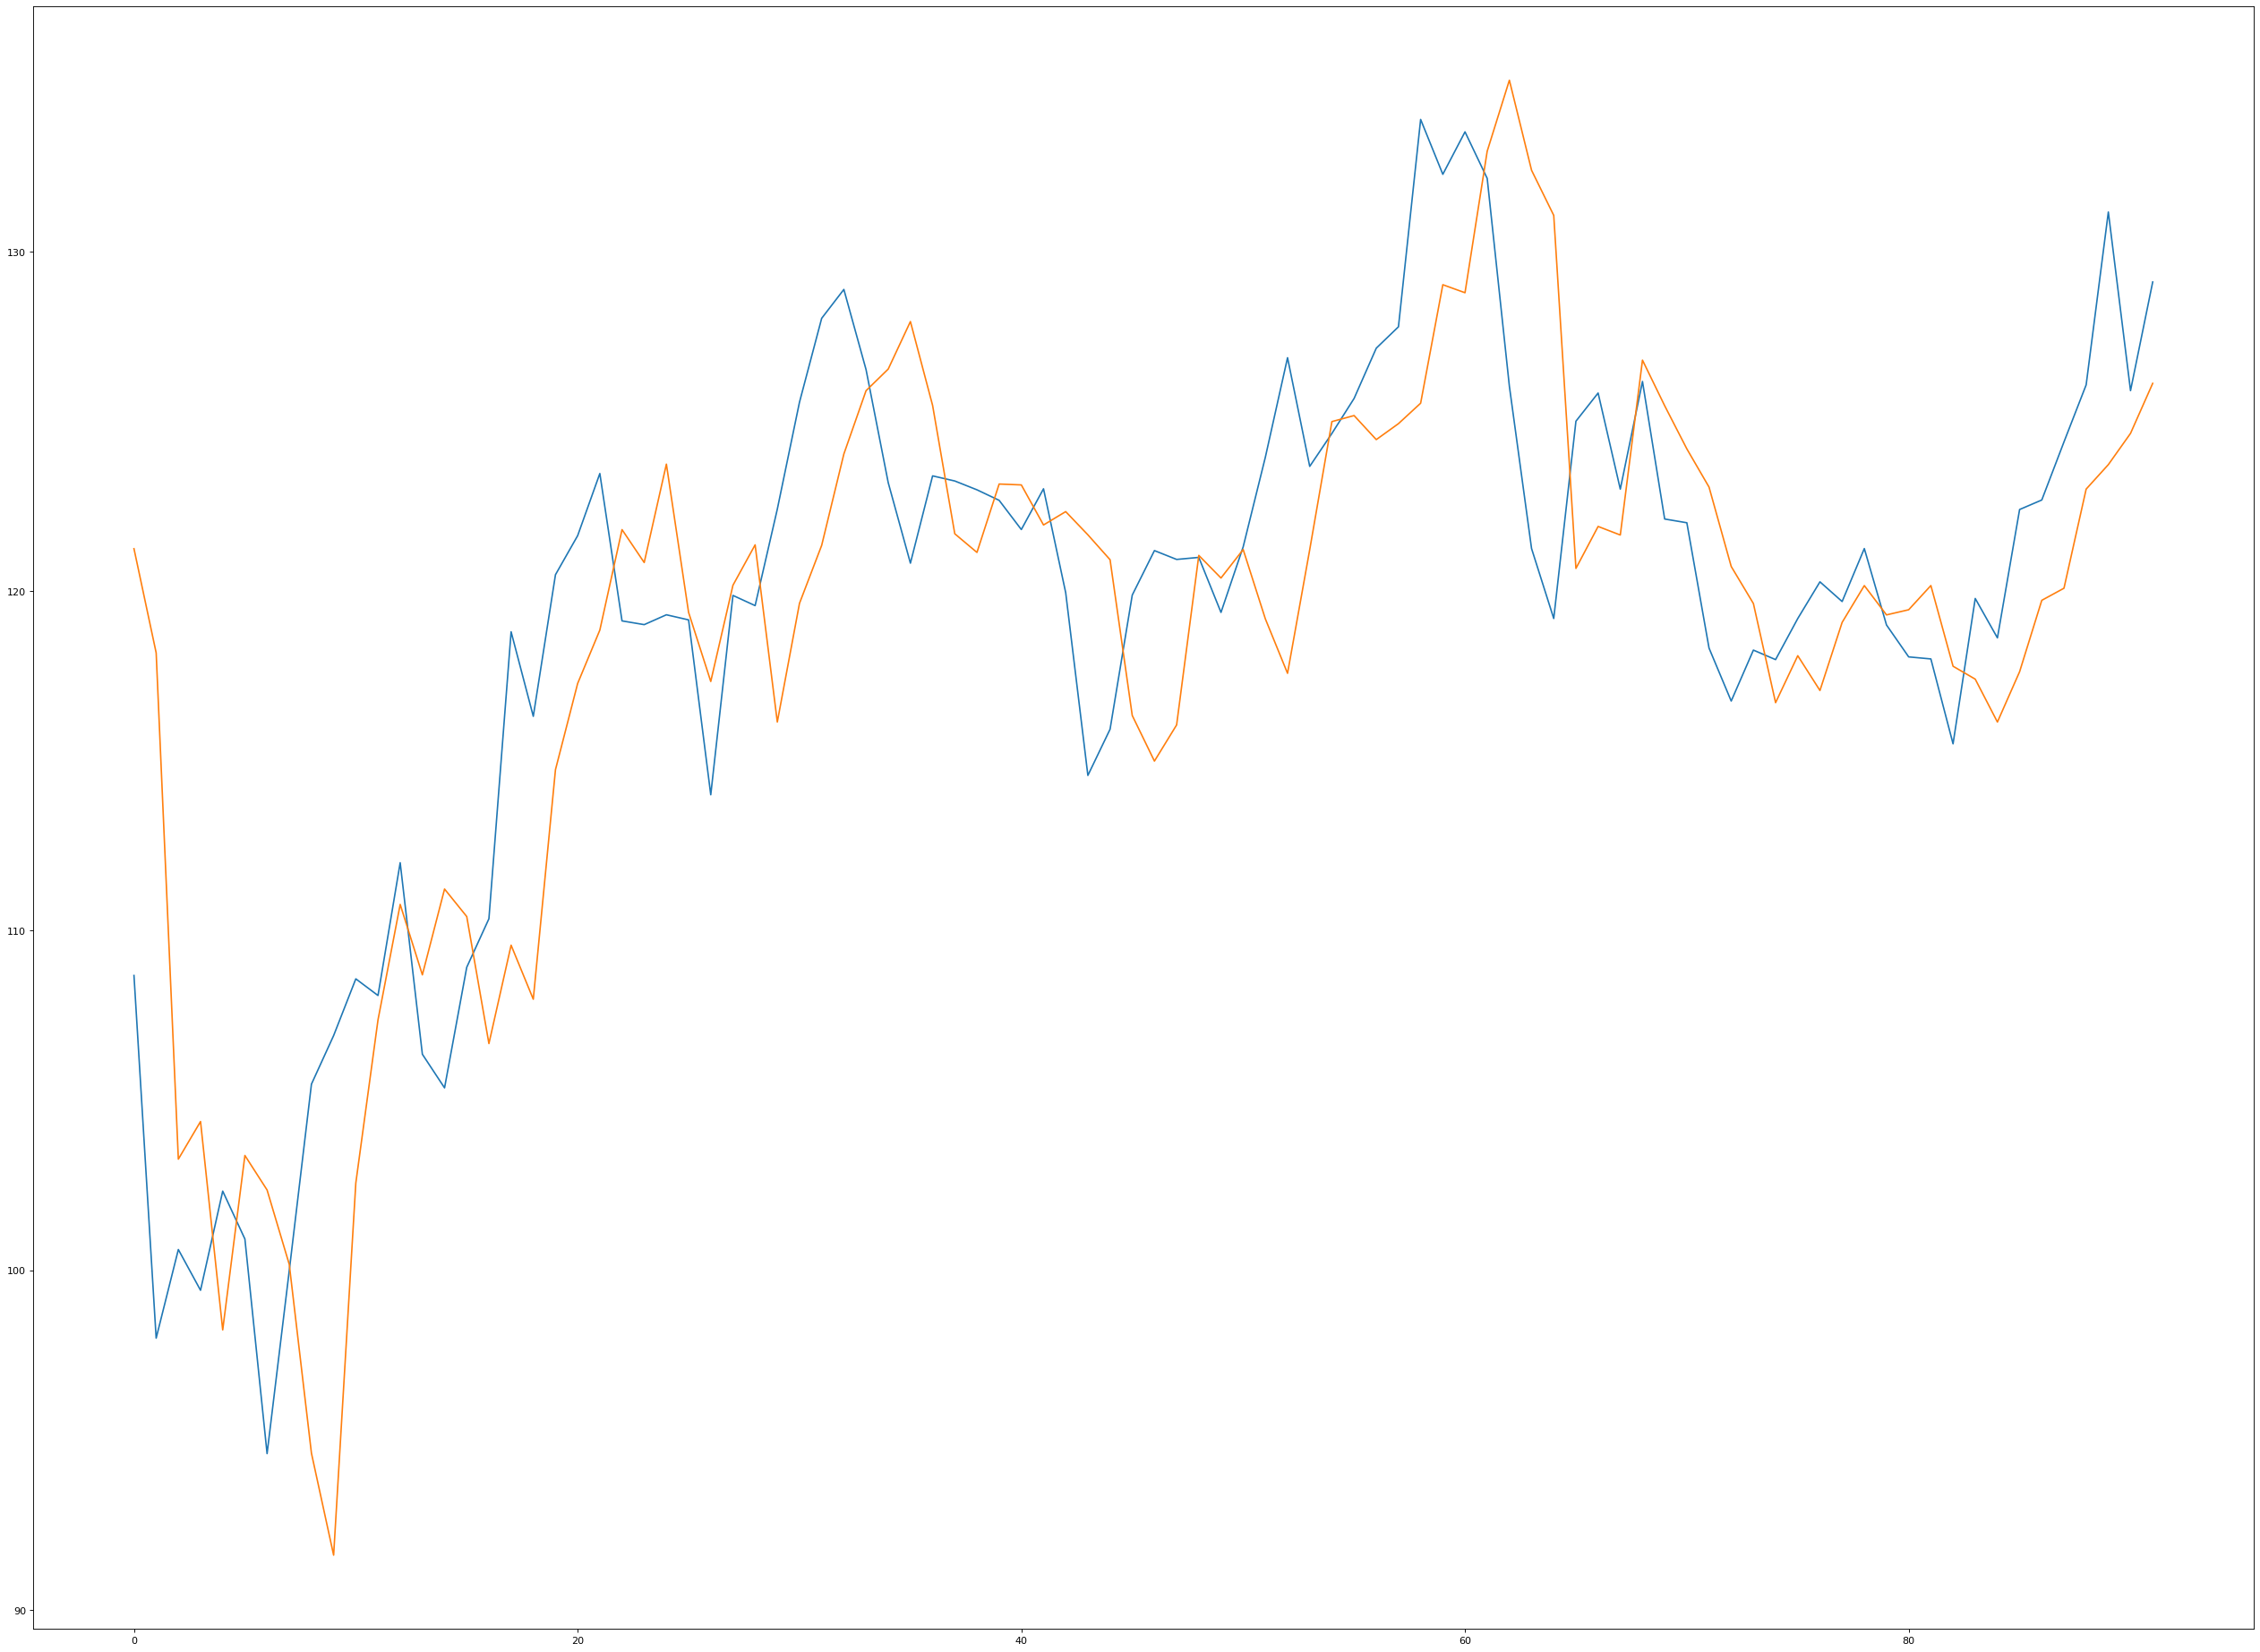

In [35]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), true_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()

##### Last 12 days + prediction of last 6 days

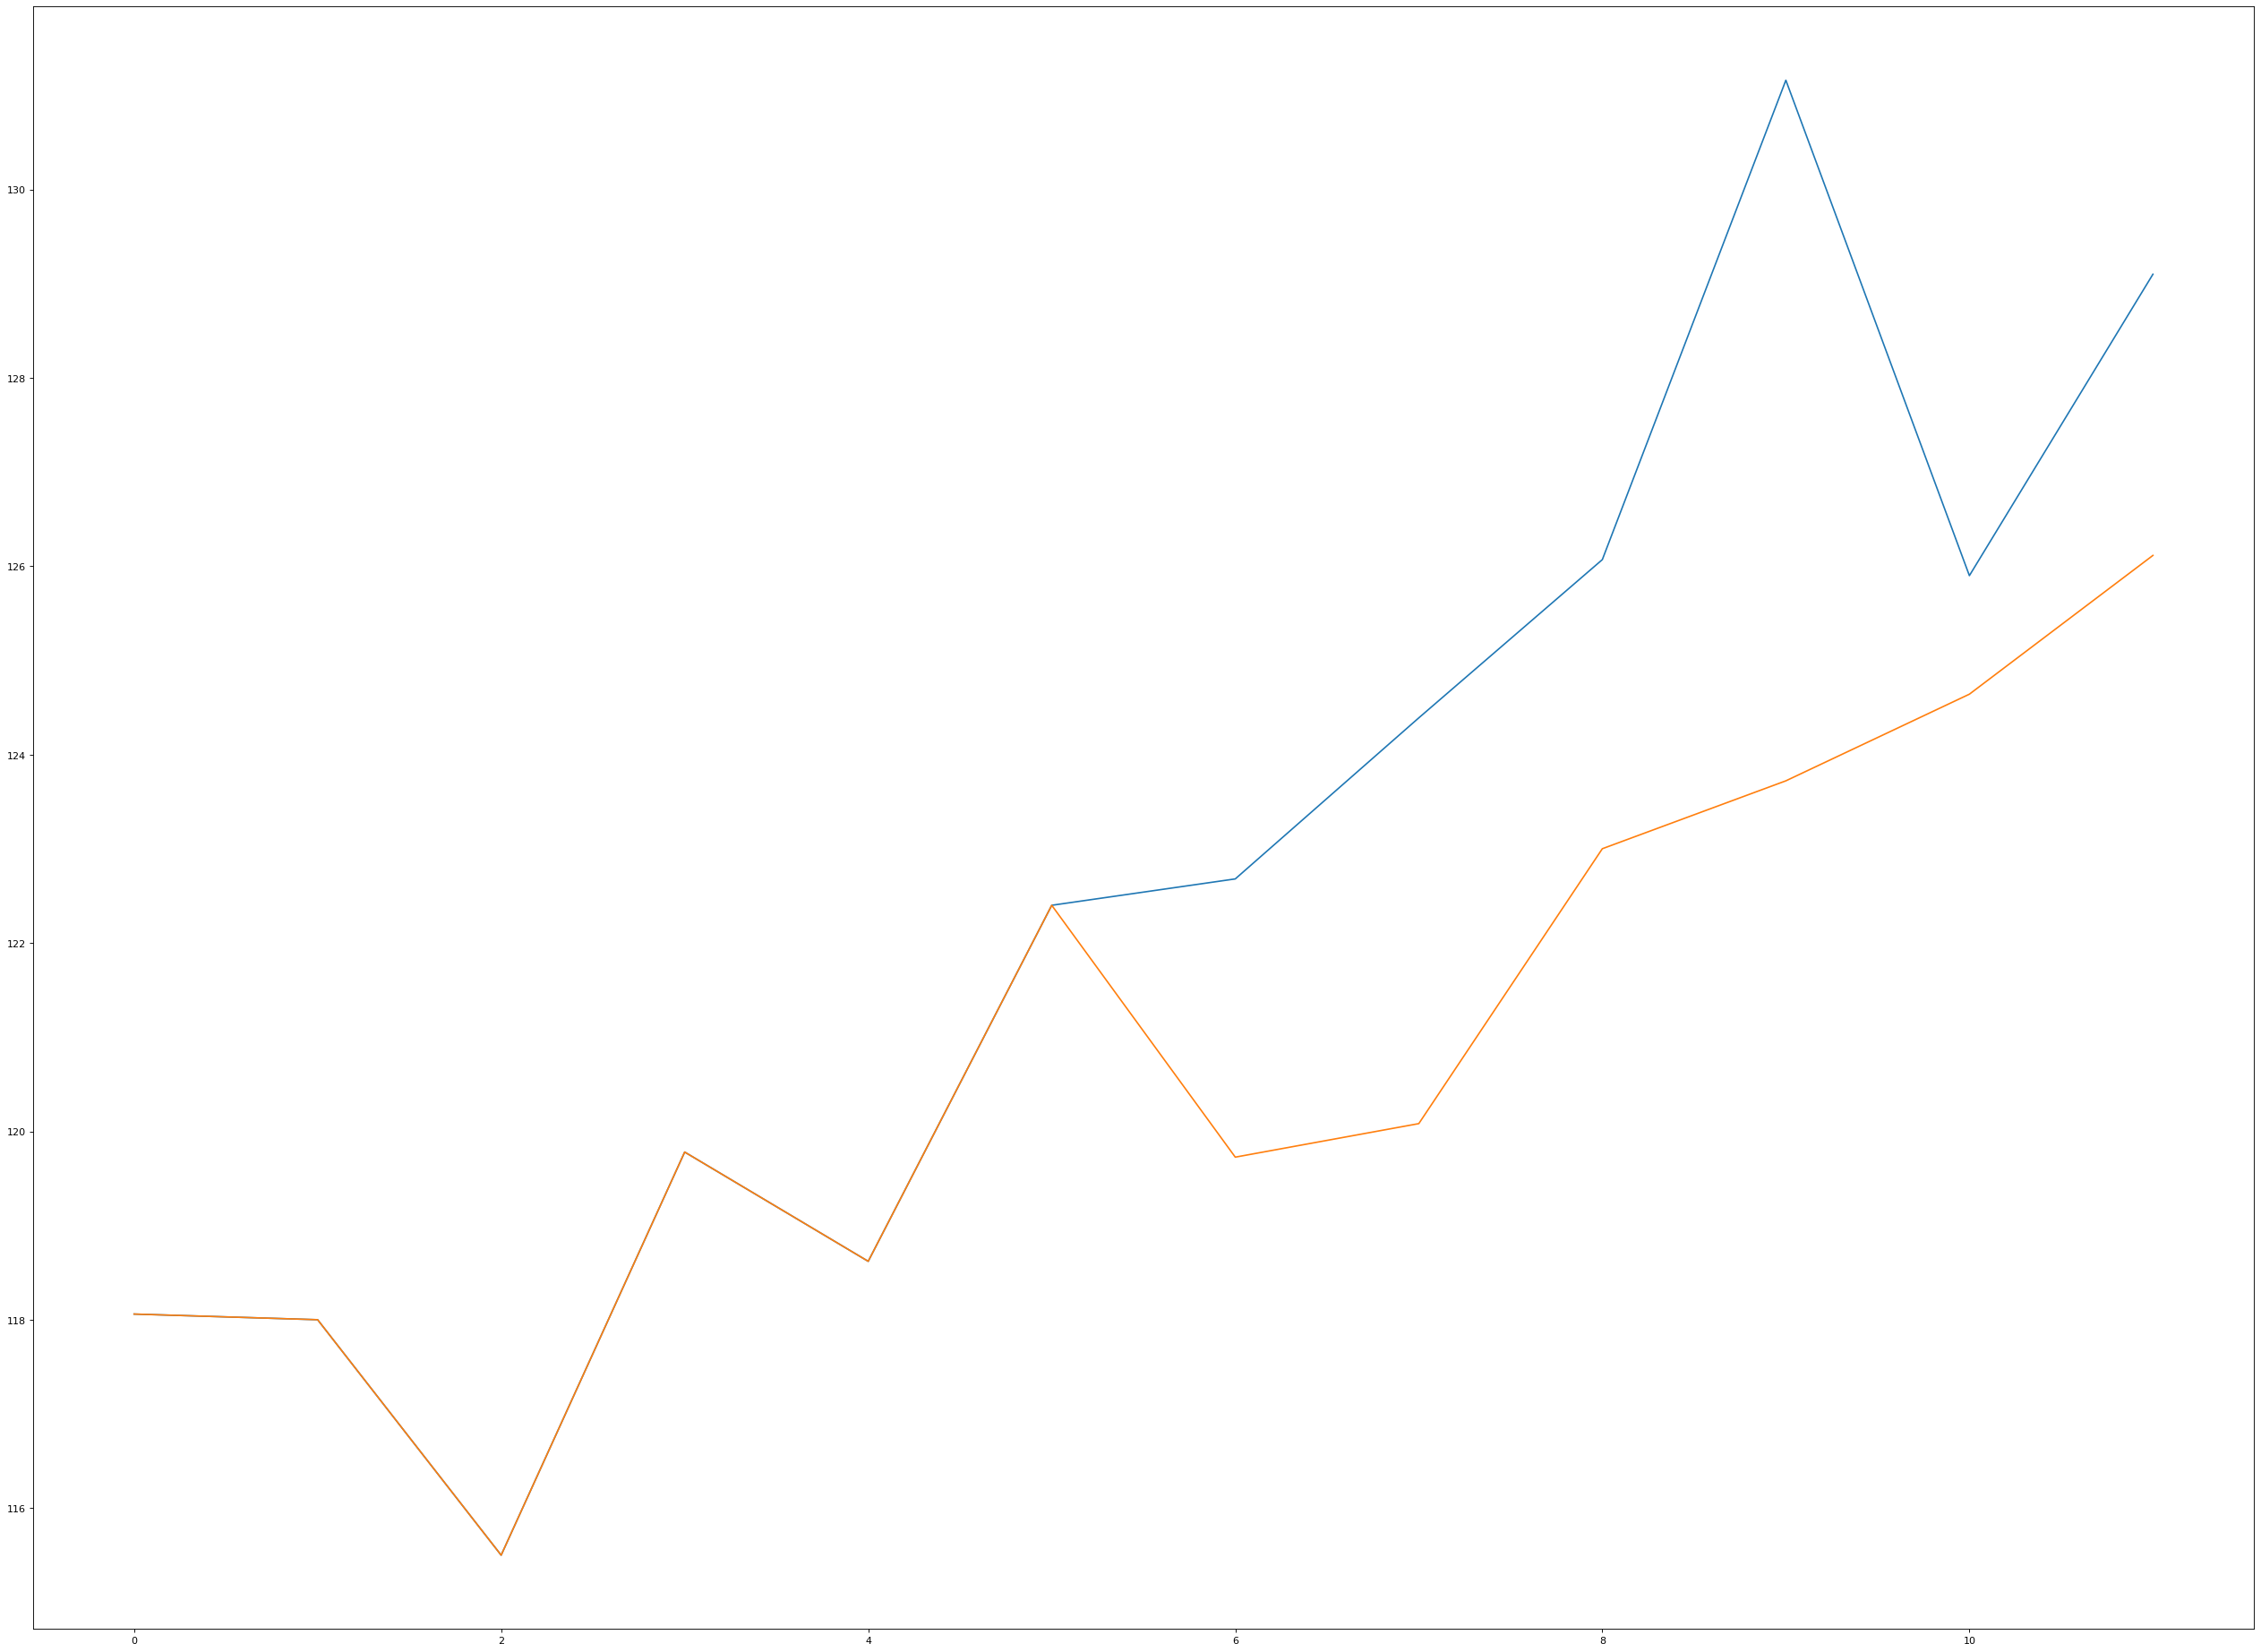

In [36]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(12), true_y_test[-12:])
plt.plot(range(12), np.append(true_y_test[-12:-6], predicted_y_test[-6:]))
plt.show()